In [1]:
import os
import requests
import dotenv
import time
import numpy as np
import pandas as pd
import alpaca_trade_api as alpaca_api
import krakenex
import pykrakenapi
import pandas_montecarlo

%matplotlib inline

In [2]:
def random_portfolios_generator(tickers, n):
    random_portfolios = pd.DataFrame({'ticker':tickers})
    for n in range(0, n):
        random_portfolios[f'random weights {n+1}'] = [np.random.rand() for i in range (0, len(tickers))]
        random_portfolios[f'random weights {n+1}'] = random_portfolios[f'random weights {n+1}'] / sum(random_portfolios[f'random weights {n+1}'])
    return(random_portfolios)

In [3]:
dotenv.load_dotenv()

True

In [4]:
alpaca_api_key = os.getenv('alpaca_api_key')
alpaca_secret_key = os.getenv('alpaca_secret_key')
kraken_api_key = os.getenv('kraken_api_key')
kraken_secret_key = os.getenv('kraken_secret_key')

print(type(alpaca_api_key))
print(type(alpaca_secret_key))
print(type(kraken_api_key))
print(type(kraken_secret_key))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [5]:
alpaca = alpaca_api.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")

faangmula_tickers =  ['AAPL',  'ABNB', 'AMZN', 'FB', 'GOOG', 'LYFT', 'MSFT', 'NFLX', 'UBER']
start = pd.Timestamp('2015-12-01', tz='America/New_York').isoformat()

faangmula_original = alpaca.get_bars(faangmula_tickers, alpaca_api.TimeFrame.Day, start = start).df
faangmula_original

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2015-12-01 05:00:00+00:00,118.73,118.810,116.860,117.34,34852374,187129,117.756760,AAPL
2015-12-02 05:00:00+00:00,117.00,118.110,116.080,116.28,33385643,180616,117.151198,AAPL
2015-12-03 05:00:00+00:00,116.55,116.790,114.220,115.20,41560785,245330,115.434888,AAPL
2015-12-04 05:00:00+00:00,115.20,119.250,115.110,119.03,57776977,307788,118.187290,AAPL
2015-12-07 05:00:00+00:00,118.98,119.860,117.810,118.28,32080754,190809,118.509111,AAPL
...,...,...,...,...,...,...,...,...
2022-04-04 04:00:00+00:00,36.40,36.930,36.215,36.51,20197208,146275,36.621379,UBER
2022-04-05 04:00:00+00:00,36.43,36.610,34.720,34.96,20987999,153337,35.188058,UBER
2022-04-06 04:00:00+00:00,33.82,34.000,32.550,33.41,29163174,203021,33.287397,UBER


In [6]:
faangmula = faangmula_original.drop(['open', 'high', 'low', 'volume', 'trade_count', 'vwap'], axis = 1).pivot(columns = 'symbol')
faangmula.index = faangmula.index.date
faangmula.columns = faangmula_tickers
faangmula

,AAPL,ABNB,AMZN,FB,GOOG,LYFT,MSFT,NFLX,UBER
2015-12-01,117.34,NaN,679.06,107.12,767.04,NaN,55.22,125.37,NaN
2015-12-02,116.28,NaN,676.01,106.07,762.38,NaN,55.21,128.93,NaN
2015-12-03,115.20,NaN,666.25,104.38,752.54,NaN,54.20,126.81,NaN
2015-12-04,119.03,NaN,672.64,106.18,766.81,NaN,55.91,130.93,NaN
2015-12-07,118.28,NaN,669.83,105.61,763.25,NaN,55.81,125.36,NaN
...,...,...,...,...,...,...,...,...,...
2022-04-04,178.44,177.02,3366.93,233.89,2872.85,38.96,314.97,391.50,36.51
2022-04-05,175.06,171.21,3281.10,231.84,2821.26,37.15,310.88,380.15,34.96
2022-04-06,171.59,164.66,3175.12,223.30,2743.52,36.08,299.50,368.35,33.41
2022-04-07,172.14,165.91,3155.69,222.95,2729.30,34.61,301.37,362.15,32.27


In [7]:
# Market capitalization data in trillions of dollars, sourced from Trading View on April 6, 2022.

faangmula_caps_list = [2.804, 0.105855, 1.616, 0.60781, 1.81, 0.012576, 2.245, 0.163534, 0.065299]
faangmula_cap_portfolio = pd.DataFrame({'tickers':faangmula_tickers, 'market cap weights':[market_cap / sum(faangmula_caps_list) for market_cap in faangmula_caps_list]}).set_index('tickers')
faangmula_cap_portfolio

,market cap weights
tickers,
AAPL,0.297347
ABNB,0.011225
AMZN,0.171367
FB,0.064454
GOOG,0.191939
LYFT,0.001334
MSFT,0.238068
NFLX,0.017342
UBER,0.006925


In [8]:
faangmula_cap_daily_returns = faangmula.pct_change().fillna(0.0).dot(faangmula_cap_portfolio)
faangmula_cap_daily_returns.columns = ['faangmula']
faangmula_cap_daily_returns

,faangmula
2015-12-01,0.000000
2015-12-02,-0.004804
2015-12-03,-0.013380
2015-12-04,0.024355
2015-12-07,-0.004990
...,...
2022-04-04,0.024182
2022-04-05,-0.018331
2022-04-06,-0.029120
2022-04-07,-0.000202


In [9]:
random_faangmula_portfolios = random_portfolios_generator(faangmula_tickers, 10)
random_faangmula_portfolios

,ticker,random weights 1,random weights 2,random weights 3,random weights 4,random weights 5,random weights 6,random weights 7,random weights 8,random weights 9,random weights 10
0,AAPL,0.230685,0.179243,0.011995,0.146482,0.120716,0.019343,0.017792,0.037189,0.027084,0.094278
1,ABNB,0.049871,0.181117,0.165006,0.026219,0.079977,0.122881,0.008053,0.072766,0.181107,0.111597
2,AMZN,0.044291,0.074237,0.188784,0.063285,0.049388,0.156339,0.203708,0.176999,0.175464,0.006677
3,FB,0.043866,0.127866,0.096986,0.108298,0.082048,0.069121,0.169260,0.206964,0.148283,0.190144
4,GOOG,0.086879,0.083361,0.033805,0.032302,0.208158,0.067072,0.213134,0.154448,0.055571,0.095434
5,LYFT,0.211320,0.109084,0.187386,0.039185,0.146400,0.100278,0.001311,0.005177,0.129728,0.022163
6,MSFT,0.081423,0.126559,0.029388,0.174519,0.021821,0.183125,0.091520,0.037468,0.076727,0.080537
7,NFLX,0.126370,0.056986,0.094425,0.171876,0.141344,0.180351,0.151295,0.099444,0.125445,0.268801
8,UBER,0.125295,0.061548,0.192225,0.237834,0.150147,0.101489,0.143927,0.209545,0.080592,0.130370


In [16]:
random_faangmula_daily_returns_list = []
for n in range(0, (len(random_faangmula_portfolios.columns) - 1)):
        random_faangmula_daily_returns_list.append(faangmula.pct_change().fillna(0.0).dot(list(random_faangmula_portfolios.loc[:, f'random weights {n + 1}'])))

random_faangmula_daily_returns = pd.concat(random_faangmula_daily_returns_list, axis = 'columns', join = 'inner')

for n in range(0, (len(random_faangmula_portfolios.columns) - 1)):
        random_faangmula_daily_returns = random_faangmula_daily_returns.rename(columns = {n: f'random faangmula portfolio {n + 1}'})

random_faangmula_daily_returns

,random faangmula portfolio 1,random faangmula portfolio 2,random faangmula portfolio 3,random faangmula portfolio 4,random faangmula portfolio 5,random faangmula portfolio 6,random faangmula portfolio 7,random faangmula portfolio 8,random faangmula portfolio 9,random faangmula portfolio 10
2015-12-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-12-02,0.000333,-0.002117,0.000564,0.001984,0.000628,0.003126,0.000250,-0.001281,0.000724,0.004293
2015-12-03,-0.008170,-0.009102,-0.006909,-0.010435,-0.008552,-0.010719,-0.012716,-0.010512,-0.009331,-0.011127
2015-12-04,0.017173,0.016301,0.008518,0.019047,0.015130,0.016243,0.017309,0.013845,0.012691,0.019561
2015-12-07,-0.007799,-0.005164,-0.005611,-0.009543,-0.008426,-0.009457,-0.009461,-0.007099,-0.007432,-0.013665
...,...,...,...,...,...,...,...,...,...,...
2022-04-04,0.028998,0.027552,0.029290,0.027386,0.028828,0.029355,0.028945,0.028031,0.030632,0.031809
2022-04-05,-0.028938,-0.024826,-0.031898,-0.025944,-0.028185,-0.026769,-0.022851,-0.024698,-0.027309,-0.024402
2022-04-06,-0.030466,-0.032159,-0.035079,-0.034227,-0.031866,-0.034218,-0.033814,-0.035015,-0.034138,-0.033698
2022-04-07,-0.014176,-0.005851,-0.015791,-0.011571,-0.013847,-0.009859,-0.009438,-0.010337,-0.009800,-0.009057


In [17]:
faangmula_daily_returns = pd.concat([faangmula_cap_daily_returns, random_faangmula_daily_returns], axis = 1, join = 'inner')
faangmula_daily_returns

,faangmula,random faangmula portfolio 1,random faangmula portfolio 2,random faangmula portfolio 3,random faangmula portfolio 4,random faangmula portfolio 5,random faangmula portfolio 6,random faangmula portfolio 7,random faangmula portfolio 8,random faangmula portfolio 9,random faangmula portfolio 10
2015-12-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-12-02,-0.004804,0.000333,-0.002117,0.000564,0.001984,0.000628,0.003126,0.000250,-0.001281,0.000724,0.004293
2015-12-03,-0.013380,-0.008170,-0.009102,-0.006909,-0.010435,-0.008552,-0.010719,-0.012716,-0.010512,-0.009331,-0.011127
2015-12-04,0.024355,0.017173,0.016301,0.008518,0.019047,0.015130,0.016243,0.017309,0.013845,0.012691,0.019561
2015-12-07,-0.004990,-0.007799,-0.005164,-0.005611,-0.009543,-0.008426,-0.009457,-0.009461,-0.007099,-0.007432,-0.013665
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04,0.024182,0.028998,0.027552,0.029290,0.027386,0.028828,0.029355,0.028945,0.028031,0.030632,0.031809
2022-04-05,-0.018331,-0.028938,-0.024826,-0.031898,-0.025944,-0.028185,-0.026769,-0.022851,-0.024698,-0.027309,-0.024402
2022-04-06,-0.029120,-0.030466,-0.032159,-0.035079,-0.034227,-0.031866,-0.034218,-0.033814,-0.035015,-0.034138,-0.033698
2022-04-07,-0.000202,-0.014176,-0.005851,-0.015791,-0.011571,-0.013847,-0.009859,-0.009438,-0.010337,-0.009800,-0.009057


In [19]:
faangmula_daily_returns.corr()

,faangmula,random faangmula portfolio 1,random faangmula portfolio 2,random faangmula portfolio 3,random faangmula portfolio 4,random faangmula portfolio 5,random faangmula portfolio 6,random faangmula portfolio 7,random faangmula portfolio 8,random faangmula portfolio 9,random faangmula portfolio 10
faangmula,1.000000,0.844914,0.909508,0.691516,0.871138,0.833629,0.834631,0.872862,0.844772,0.810677,0.852027
random faangmula portfolio 1,0.844914,1.000000,0.961136,0.924970,0.960916,0.980808,0.918917,0.861044,0.897506,0.921024,0.899570
random faangmula portfolio 2,0.909508,0.961136,1.000000,0.906145,0.955125,0.963991,0.941277,0.907245,0.936790,0.955380,0.931698
random faangmula portfolio 3,0.691516,0.924970,0.906145,1.000000,0.918879,0.956763,0.938690,0.865874,0.924629,0.963453,0.874927
random faangmula portfolio 4,0.871138,0.960916,0.955125,0.918879,1.000000,0.977420,0.966209,0.946667,0.964552,0.949537,0.967135
random faangmula portfolio 5,0.833629,0.980808,0.963991,0.956763,0.977420,1.000000,0.962888,0.924174,0.954500,0.965131,0.944900
random faangmula portfolio 6,0.834631,0.918917,0.941277,0.938690,0.966209,0.962888,1.000000,0.966723,0.970038,0.986497,0.968558
random faangmula portfolio 7,0.872862,0.861044,0.907245,0.865874,0.946667,0.924174,0.966723,1.000000,0.983313,0.947752,0.963959
random faangmula portfolio 8,0.844772,0.897506,0.936790,0.924629,0.964552,0.954500,0.970038,0.983313,1.000000,0.972686,0.961815
random faangmula portfolio 9,0.810677,0.921024,0.955380,0.963453,0.949537,0.965131,0.986497,0.947752,0.972686,1.000000,0.952627


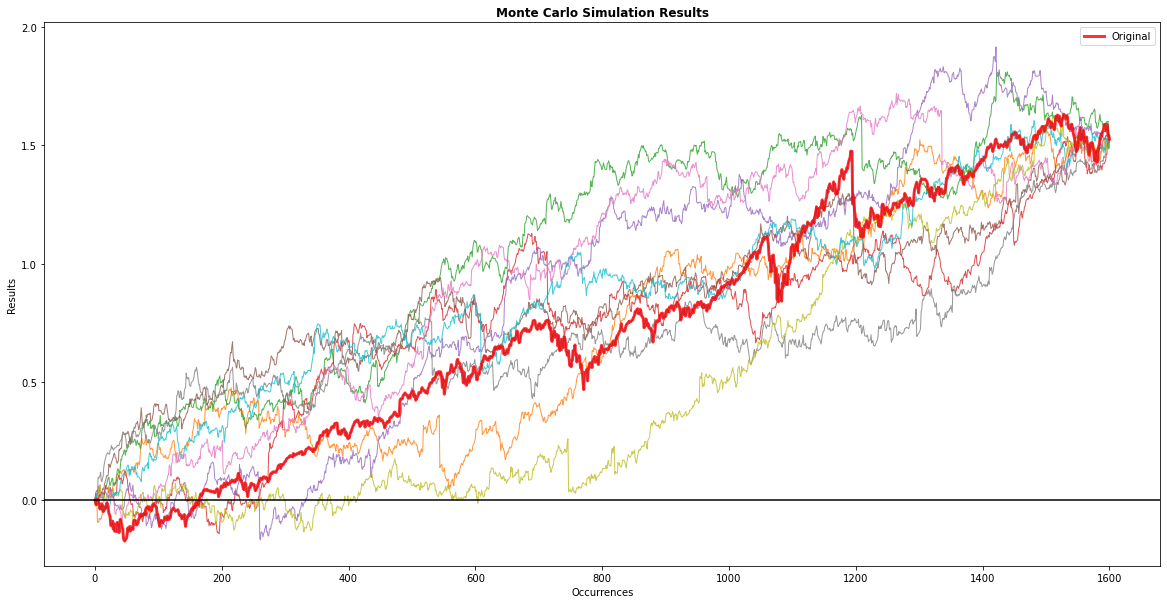

In [15]:
montecarlo_faangmula = faangmula_daily_returns['faangmula'].montecarlo(sims=10, bust=-0.1, goal=1)
montecarlo_faangmula.plot(figsize = (20, 10))